In [1]:
!pip install transformers

## BERT를 활용한 영화 리뷰 감성분석
 - 네이버 영화 리뷰 데이터 [(링크)](https://github.com/e9t/nsmc/)
 - 사전학습된 BERT 모델 활용 (with Huggingface)
 - bert-base-multilingual-cased, KoBERT 모델 사용

In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Dense, Input, LSTM, Conv1D, MaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import re
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

#### 1. 데이터 로드 및 탐색

In [17]:
DATA_PATH = ''
df = pd.read_csv(DATA_PATH + 'naver_movie/ratings.txt', header=0, delimiter='\t', quoting=3)
df = df.dropna()
df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [18]:
# MAX_LEN를 정하기 위해 기술통계량 확인
df['document'].apply(len).describe()

count    199992.000000
mean         35.233459
std          29.561006
min           1.000000
25%          16.000000
50%          27.000000
75%          42.000000
max         146.000000
Name: document, dtype: float64

#### 2. 데이터 전처리

In [19]:
document = list(df['document'])
label = list(df['label'])
x_train, x_temp, y_train, y_temp = train_test_split(document, label, test_size=0.4)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5)

In [20]:
# 사전학습 BERT 모델
model_ckpt = {
    'normal': "bert-base-multilingual-cased",
    'kobert': "kykim/bert-kor-base"    # 한글로 만든 KoBERT모델
}    

# 저장경로
save_path = 'bert'

# Tokenizer 정의
tokenizer = BertTokenizer.from_pretrained(model_ckpt['normal'], cache_dir=save_path, do_lower_case=False)


MAX_LEN = 60
# BERT tokenizer 함수 정의
def bert_tokenizer(sent, max_len):
    '''
    BERT의 입력을 만드는 tokenizer 함수 정의
    1) input_id : 단어 ID
    2) attention_mask : 마스크 정보
    3) token_type_ids : 해당 단어가 문장A에 속하는지 B에 속하는지에 대한 정보
    
    Inputs:
    sent : 입력문장,
    max_len : 최대 임베딩 길이 
    
    Returns:
    input_id, attention_mask, token_type_id
    '''
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True,      # Add '[CLS]' and '[SEP]'. Default is True
        max_length = max_len,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True,   # Construct attn. masks.
        truncation = True
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids']  # differentiate two sentences
    
    return input_id, attention_mask, token_type_id


# encode_plus 메서드
# https://huggingface.co/transformers/v2.11.0/main_classes/tokenizer.html참고

In [24]:
def build_data(doc):
    x_ids = []
    x_msk = []
    x_typ = []

    for sent in tqdm(doc):
        input_id, attention_mask, token_type_id = bert_tokenizer(sent, MAX_LEN)
        x_ids.append(input_id)
        x_msk.append(attention_mask)
        x_typ.append(token_type_id)

    x_ids = np.array(x_ids, dtype=int)
    x_msk = np.array(x_msk, dtype=int)
    x_typ = np.array(x_typ, dtype=int)

    return x_ids, x_msk, x_typ

In [25]:
# 데이터셋 생성
x_train_ids, x_train_msk, x_train_typ = build_data(x_train)
x_valid_ids, x_valid_msk, x_valid_typ = build_data(x_valid)
x_test_ids, x_test_msk, x_test_typ = build_data(x_test)

y_train = np.array(y_train).reshape(-1, 1)
y_valid = np.array(y_valid).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

print(x_train_ids.shape, y_train.shape)
print(x_valid_ids.shape, y_valid.shape)
print(x_test_ids.shape, y_test.shape)

x_train = [x_train_ids, x_train_msk, x_train_typ]
x_valid = [x_valid_ids, x_valid_msk, x_valid_typ]
x_test = [x_test_ids, x_test_msk, x_test_typ]

x_train_ids[0], x_train_msk[0], x_train_typ[0]

  0%|          | 0/119995 [00:00<?, ?it/s]

  0%|          | 0/39998 [00:00<?, ?it/s]

  0%|          | 0/39999 [00:00<?, ?it/s]

(119995, 60) (119995, 1)
(39998, 60) (39998, 1)
(39999, 60) (39999, 1)


(array([   101,   8898,  22333, 119398,  11287, 118965,  10892,   9708,
         59456,   9464,  10892,   9281,  38709,    100,    102,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

#### 3. BERT 모델 정의 및 파인 튜닝

In [26]:
bert_model = TFBertModel.from_pretrained(model_ckpt['normal'], cache_dir=save_path)

# bert_model을 확인하면 trainable params = 177,853,440
# bert_model.summary()

# 만약 bert모델을 학습시키지 않고 싶다면
# BERT_model.trainable 메서드를 통해 학습모드 중단
bert_model.trainable = False
bert_model.summary() # bert_model을 다시 확인하면 trainable params 확인가능

Downloading:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  177853440 
                                                                 
Total params: 177,853,440
Trainable params: 0
Non-trainable params: 177,853,440
_________________________________________________________________


In [27]:
# BERT 입력
# ---------
x_input_ids = Input(batch_shape = (None, MAX_LEN), dtype = tf.int32)
x_input_msk = Input(batch_shape = (None, MAX_LEN), dtype = tf.int32)
x_input_typ = Input(batch_shape = (None, MAX_LEN), dtype = tf.int32)

# BERT 출력
# [0]: (None, 60, 768) - sequence_output, 
# [1]: (None, 768) - pooled_output (모델의 맨 마지막 layer의 CLS토큰 벡터)
# ------------------------------------------------------------------------
# output_bert = bert_model([x_input_ids, x_input_msk, x_input_typ])[0]
output_bert = bert_model([x_input_ids, x_input_msk, x_input_typ])[1]

# Downstream task : 네이버 영화 리뷰 감성분석
# -------------------------------------
y_output = Dense(1, activation = 'sigmoid')(output_bert)
model = Model([x_input_ids, x_input_msk, x_input_typ], y_output)
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.01))
model.summary()

## FFN 말고 다른 layer를 사용하면 성능이 좋아질까?
# CNN 이용
# y_cnn = Conv1D(filters=32 , kernel_size=12, strides=2, activation='relu')(output_bert)
# y_maxpool = MaxPool1D(pool_size= 12, strides=2)(y_cnn)
# y_output = Dense(1, activation='sigmoid')(y_maxpool)
# model = Model([x_input_ids, x_input_msk, x_input_typ], y_output)
# model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.01))
# model.summary()

# LSTM 이용
# y_lstm = LSTM(128)(y_output)
# y_output = Dense(64, activation='sigmoid')(y_lstm)
# model = Model([x_input_ids, x_input_msk, x_input_typ], y_lstm)
# model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.01))
# model.summary

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  177853440   ['input_4[0][0]',                
                                thPoolingAndCrossAt               'input_5[0][0]',          

In [28]:
# 모델 훈련
hist = model.fit(x_train, y_train, validation_data = (x_valid, y_valid), epochs=5, batch_size=32)

Epoch 1/5
3750/3750 [==============================] - 671s 175ms/step - loss: 0.6381 - val_loss: 0.5933
Epoch 2/5
3750/3750 [==============================] - 697s 186ms/step - loss: 0.6308 - val_loss: 0.5920
Epoch 3/5
3750/3750 [==============================] - 699s 186ms/step - loss: 0.6229 - val_loss: 0.5997
Epoch 4/5
3750/3750 [==============================] - 705s 188ms/step - loss: 0.6247 - val_loss: 0.5817
Epoch 5/5
3750/3750 [==============================] - 712s 190ms/step - loss: 0.6258 - val_loss: 0.5817


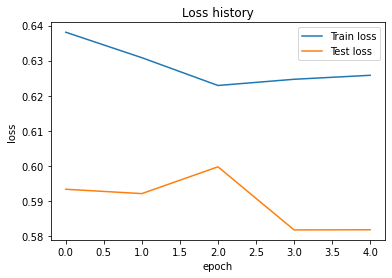

In [29]:
# Loss history
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

#### 4. 모델 성능 확인 및 결과비교

In [15]:
# test 데이터로 학습 성능 평가
pred = model.predict(x_test)
y_pred = np.where(pred > 0.5, 1, 0)
accuracy = (y_pred == y_test).mean()
print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))


# 테스트 결과들
# Model   Trainable    Result
# normal      T        50.00%
# normal      F        69.32%
# kobert      T        50.24%
# kobert      F        75.42%

1250/1250 [==============================] - 157s 123ms/step

Accuracy = 75.42 %


### 모델 weight 저장 및 불러오기

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.train import latest_checkpoint
import os

# DATA_PATH 아래 kykim_bert 폴더를 만들어 놓는다.
# ckpt_path = DATA_PATH + 'kykim_bert/weights.h5'
# ckpt_dir = DATA_PATH + 'kykim_bert'

# huggingface.co --> (우측상단) models --> (왼쪽 메뉴) languages에서 ko --> (오른쪽) kykim/bert-kor-base 클릭
checkpoint = "kykim/bert-kor-base"
tokenizer = BertTokenizer.from_pretrained(checkpoint, cache_dir = 'bert', do_lower_case=False)
word2idx = tokenizer.vocab
idx2word = {v:k for k, v in word2idx.items()}

# 저장된 weight가 있으면 사용
if os.path.exists(ckpt_path):
    model.load_weights(ckpt_path)
    print('학습된 weight가 적용됐습니다.')

# Create a callback that saves the model's weights, every epochs
cp_callback = ModelCheckpoint(filepath=ckpt_path, 
                              save_weights_only=True, 
                              verbose=1,
                              save_freq=1)

# 모델 훈련시 callbacks 추가
hist = model.fit(x_train, y_train, 
                 validation_data = (x_valid, y_valid), 
                 epochs=5, 
                 batch_size=64,
                 callbacks=[cp_callback])    # 


### 0. BERT Tokenizer 테스트

In [18]:
# 사전학습 BERT 모델
model_ckpt = {
    'normal': "bert-base-multilingual-cased",
    'kobert': "kykim/bert-kor-base"    # 한글로 만든 KoBERT모델
}    

# 저장경로
save_path = 'bert'

tokenizer = BertTokenizer.from_pretrained(model_ckpt['normal'], cache_dir=save_path, do_lower_case=False)   # 사전학습 된 사전을 읽어온다
word2idx = tokenizer.vocab
idx2word = {v:k for k, v in word2idx.items()}

In [19]:
# print(idx2word)

In [20]:
# BERT tokenizer 테스트
enc = tokenizer.encode('I love you'.split())
print(enc)
print([idx2word[x] for x in enc])

dec = tokenizer.decode(enc)
print(dec)

[101, 146, 16138, 13028, 102]
['[CLS]', 'I', 'love', 'you', '[SEP]']
[CLS] I love you [SEP]


In [21]:
# 한글 테스트
# => 사전에 없으면 UNK 토큰으로 임베딩
sentence = '어릴때보고 지금다시봐도 재밌어요ㅋㅋ'
enc = tokenizer.encode(sentence)
print(enc)
print([idx2word[x] for x in enc])

dec = tokenizer.decode(enc)
print(dec)

[101, 9546, 85836, 118832, 30005, 11664, 9706, 40032, 11903, 14040, 118990, 12092, 100, 102]
['[CLS]', '어', '##릴', '##때', '##보', '##고', '지', '##금', '##다', '##시', '##봐', '##도', '[UNK]', '[SEP]']
[CLS] 어릴때보고 지금다시봐도 [UNK] [SEP]


In [22]:
temp = tokenizer.encode_plus(sentence, return_tensors='tf')
temp

{'input_ids': <tf.Tensor: shape=(1, 14), dtype=int32, numpy=
array([[   101,   9546,  85836, 118832,  30005,  11664,   9706,  40032,
         11903,  14040, 118990,  12092,    100,    102]])>, 'token_type_ids': <tf.Tensor: shape=(1, 14), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(1, 14), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])>}

In [21]:
text = document[0]
id, mask, typ = bert_tokenizer(text, MAX_LEN)
print(text)
print(id)
print(mask)
print(typ)

In [22]:
text_1 = [idx2word[x] for x in id]
print(text_1)

In [23]:
# 문장 복원
print((' '.join(text_1)).replace(' ##', ''))  # 원리
print()
print(tokenizer.decode(id))

print('토큰 길이 :', len(id))